# Graph Analysis for Diabetes Readmission Data

Load the data

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np

# Load the dataset
data = pd.read_csv('diabetic_data.csv')
data = data.sample(n=100, random_state=42).reset_index(drop=True)


# Select features of interest
features = [
    'race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 
    'num_procedures', 'num_medications', 'number_outpatient', 
    'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 
    'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'admission_type_id', 
    'discharge_disposition_id', 'admission_source_id', 'readmitted'
] + [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'
]

# Select and preprocess data
selected_data = data[features]

# One-hot encode categorical features
categorical_cols = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 
                    'admission_type_id', 'discharge_disposition_id', 
                    'admission_source_id', 'change', 'diabetesMed'] + [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]
one_hot_encoder = OneHotEncoder()
encoded_categorical = one_hot_encoder.fit_transform(selected_data[categorical_cols]).toarray()

# Standardize numerical features
numerical_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_outpatient', 'number_emergency', 
    'number_inpatient', 'number_diagnoses'
]
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(selected_data[numerical_cols])

# Concatenate processed features
processed_data = np.hstack([scaled_numerical, encoded_categorical])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(processed_data)

# Create a graph
G = nx.Graph()

# Define nodes, with 'readmitted' as an attribute
for idx, row in data.iterrows():
    G.add_node(idx, readmitted=row['readmitted'])

# Define a threshold for edge creation
threshold = 0.75  # Adjust this based on desired density

# Add edges based on similarity threshold
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np

# Load data from the downloaded CSV file
data = pd.read_csv("diabetic_data.csv")

# Reduce data to 10,000 samples for testing
data = data.sample(n=100, random_state=42).reset_index(drop=True)

# Select medication-related features and target variable
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 
    'change', 'diabetesMed'
]

# Encoding medication values (e.g., 'up', 'down', 'steady', 'no') as numerical
medication_data = data[medication_cols].apply(LabelEncoder().fit_transform)
target = data['readmitted']

# Concatenate target for later use in clustering
medication_data['readmitted'] = target

Build the network using cosine similarity. We’ll compute pairwise similarities between patients and use a threshold to define edges in the graph.

In [9]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(processed_data.drop(columns=['readmitted']))

# Create a graph
G = nx.Graph()

# Add nodes with readmitted status as an attribute
for idx, row in medication_data.iterrows():
    G.add_node(idx, readmitted=row['readmitted'])

# Define a similarity threshold for connecting nodes
threshold = 0.7  # Adjust based on density preference

# Add edges based on similarity threshold
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

Perform Graph Clustering using Louvain method.


In [12]:
import community as community_louvain  # This is the python-louvain package
import matplotlib.pyplot as plt

# Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Add partition labels as node attributes for visualization and analysis
for node, cluster_id in partition.items():
    G.nodes[node]['cluster'] = cluster_id

Visualize the Graph with Clusters

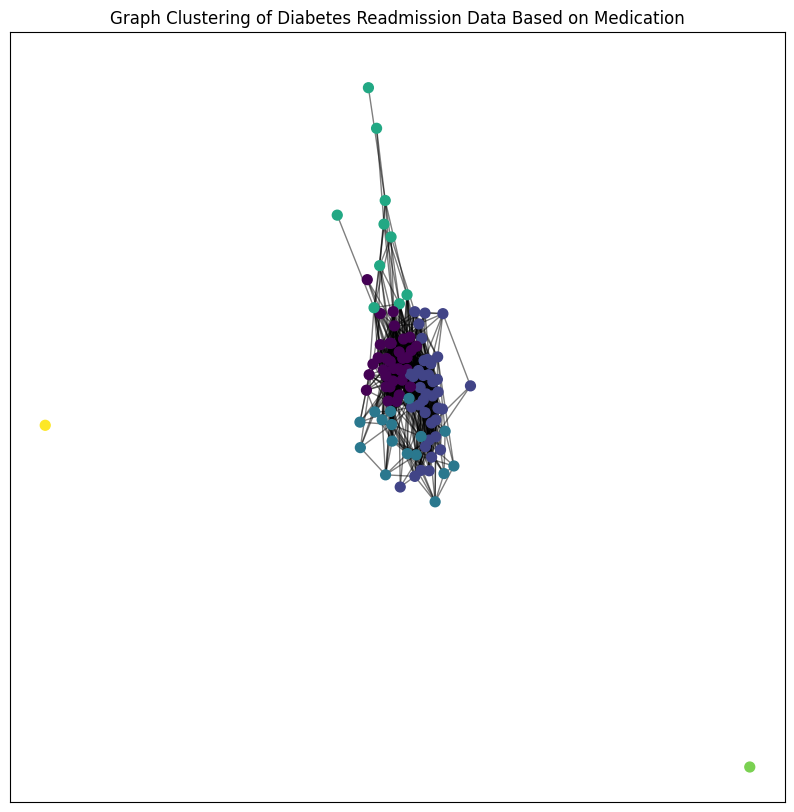

In [13]:
# Visualize graph with clusters
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization

# Draw nodes, color by cluster
node_colors = [partition[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.viridis)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title('Graph Clustering of Diabetes Readmission Data Based on Medication')
plt.show()


Analyze clusters

In [14]:
from collections import Counter

# Count readmission types in each cluster
cluster_analysis = {}
for node, cluster_id in partition.items():
    readmit_status = G.nodes[node]['readmitted']
    if cluster_id not in cluster_analysis:
        cluster_analysis[cluster_id] = []
    cluster_analysis[cluster_id].append(readmit_status)

# Display readmission distribution per cluster
for cluster_id, readmissions in cluster_analysis.items():
    print(f"Cluster {cluster_id}: {Counter(readmissions)}")


Cluster 0: Counter({'NO': 17, '>30': 12, '<30': 5})
Cluster 1: Counter({'NO': 24, '>30': 11, '<30': 3})
Cluster 2: Counter({'>30': 9, 'NO': 6, '<30': 1})
Cluster 3: Counter({'>30': 7, 'NO': 2, '<30': 1})
Cluster 5: Counter({'>30': 1})
Cluster 4: Counter({'>30': 1})


Cluster Density with 'NO' Readmission: Clusters 0 and 1 have a larger number of patients who were not readmitted ('NO'), suggesting that the profiles of patients in these clusters may share characteristics associated with lower readmission risks.

Cluster Dominance by '>30' Readmission: Clusters 2, 3, 4, and 5 are smaller but predominantly consist of patients who were readmitted after 30 days ('>30'). This could indicate that these clusters capture features that correlate with readmission risks beyond the 30-day window, potentially involving factors such as specific chronic conditions or lower acuity levels that do not necessitate rapid readmission.

Small Clusters with Specific Patterns: Clusters 4 and 5 contain very few members, each dominated by a single readmission outcome ('>30'). This indicates that these clusters may represent unique, perhaps outlier, profiles of patients with characteristics that lead to longer-term readmission rather than immediate care needs.

Patients Readmitted in <30 Days ('<30'): The <30 readmissions are scattered sparsely across clusters, with no single cluster showing a strong concentration of quick readmissions. This might suggest that short-term readmissions are influenced by more varied factors and are not as tightly correlated with specific patient profiles as those who are readmitted after 30 days.

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\fairlearn-0.11.0.dev0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\pyarrow-17.0.0-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
pip install python-louvain


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=e2961cf9622ff5e34969c43715e174da4f414b8de38506c46410f8671589eced
  Stored in directory: c:\users\jdiaz\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\fairlearn-0.11.0.dev0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\pyarrow-17.0.0-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import SpectralClustering
import community as community_louvain  # for Louvain algorithm
import matplotlib.pyplot as plt
# Load data from the downloaded CSV file
data = pd.read_csv("diabetic_data.csv")

# Reduce data to 10,000 samples for testing
data = data.sample(n=100, random_state=42).reset_index(drop=True)

# 1. Data Preprocessing
# Define imputers for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Separate numerical and categorical data
num_cols = data.select_dtypes(include=np.number).columns
cat_cols = data.select_dtypes(exclude=np.number).columns

# Impute missing values
data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# One-Hot Encode target column "Readmitted"
data = pd.get_dummies(data, columns=['readmitted'], prefix='readmitted')

In [2]:
# 2. Graph Construction
# Initialize a graph
G = nx.Graph()

# Add nodes for each patient
for idx, row in data.iterrows():
    G.add_node(idx, **row.to_dict())

# Define criteria to create edges, e.g., shared specialty or medications
for i, row_i in data.iterrows():
    for j, row_j in data.iterrows():
        if i < j:
            # Define your criteria for edge creation (e.g., shared specialty or medications)
            if row_i['medical_specialty'] == row_j['medical_specialty']:
                G.add_edge(i, j)

In [8]:
# 3. Graph Clustering Algorithms
# Betweenness Centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, 'betweenness')

# Spectral Clustering
# Extract adjacency matrix
adj_matrix = nx.adjacency_matrix(G)
spectral_cluster = SpectralClustering(n_clusters=3, affinity='precomputed')
spectral_labels = spectral_cluster.fit_predict(adj_matrix.toarray())

# Assign spectral clustering labels as node attribute
for idx, label in enumerate(spectral_labels):
    G.nodes[idx]['spectral_cluster'] = label

# Louvain Clustering (Modularity-based)
louvain_partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, louvain_partition, 'louvain_cluster')

C:\Users\jdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Louvain Clustering Modularity: 0.3262057250788883


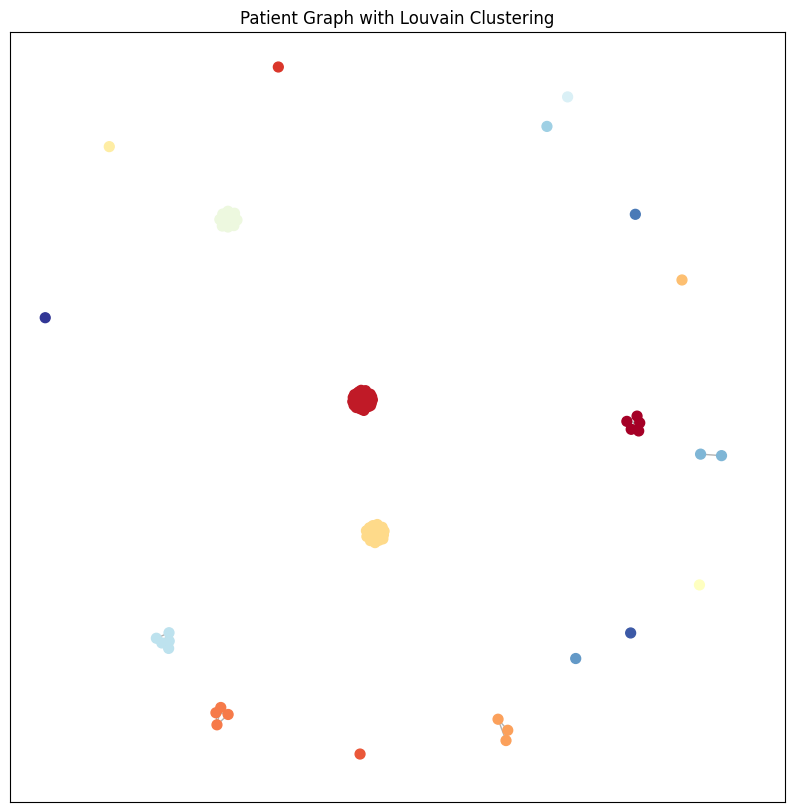

In [9]:
# 4. Evaluation: Modularity for Louvain Clustering
modularity = community_louvain.modularity(louvain_partition, G)
print("Louvain Clustering Modularity:", modularity)

# 5. Visualization
# Draw the graph with Louvain clusters
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.RdYlBu, 
                       node_color=list(louvain_partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Patient Graph with Louvain Clustering")
plt.show()

In [5]:
pip install leidenalg

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 1.9 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.6 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 2.4 MB/s eta 0:00:01
   ---------------- ----------------------- 0.8/2.0 MB 2.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.3/2.0 MB 2.2 MB/s eta 0:00:01
   ------------------------------------- -- 1.8/2.0 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 2.1 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\fairlearn-0.11.0.dev0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\pyarrow-17.0.0-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


# Leiden Algorithm:

The Leiden algorithm is more robust in modularity optimization than Louvain, especially in large and dense networks. We applied it using the leidenalg library with igraph.
Visualization Enhancements:

Cluster and Centrality Display: The visualization now scales node size according to betweenness centrality, while the color represents Leiden clusters. This shows not only the clusters but also the influential nodes within each.
Feature Distributions by Cluster: Using box plots, we can visualize the distribution of clinical features (like age and number of medications) across different clusters. This helps to identify unique characteristics within clusters.

Leiden Clustering Modularity: 0.3262057250788883


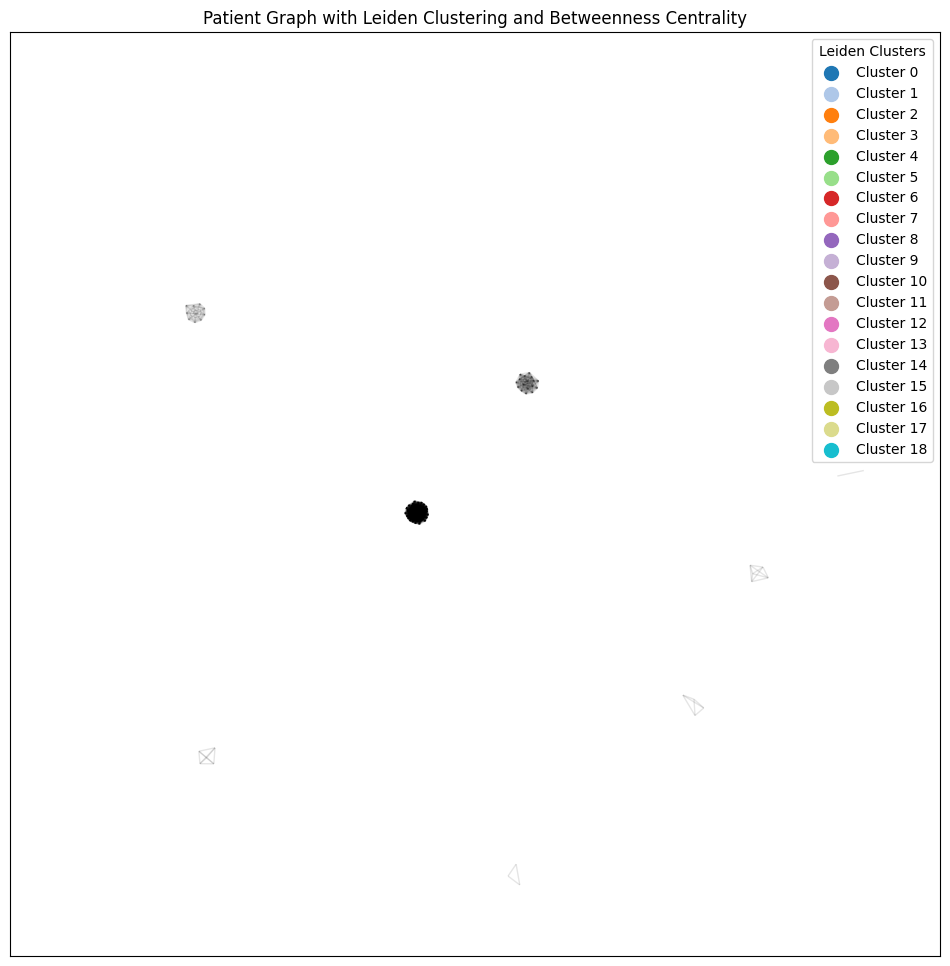

In [9]:
from leidenalg import find_partition, ModularityVertexPartition  # Leiden algorithm
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig

# 3. Advanced Graph Clustering: Leiden Algorithm
G_igraph = ig.Graph.from_networkx(G)
leiden_partition = find_partition(G_igraph, ModularityVertexPartition)
leiden_clusters = {node: community for community, nodes in enumerate(leiden_partition) for node in nodes}
nx.set_node_attributes(G, leiden_clusters, 'leiden_cluster')


# 4. Evaluation: Modularity for Leiden Clustering
modularity_leiden = G_igraph.modularity(leiden_partition)
print("Leiden Clustering Modularity:", modularity_leiden)

# 5. Enhanced Visualization
# Node size based on betweenness centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, 'betweenness')

# Define positions and plot
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))

# Draw nodes with Leiden clusters and size by centrality
unique_clusters = set(leiden_clusters.values())
cluster_colors = plt.cm.tab20.colors  # Use a color map with enough unique colors

# Create a mapping of cluster IDs to colors
color_map = {cluster: cluster_colors[i % len(cluster_colors)] for i, cluster in enumerate(unique_clusters)}
node_colors = [color_map[leiden_clusters[node]] for node in G.nodes()]
node_sizes = [betweenness[node] * 1000 for node in G.nodes()]  # Scale for visibility

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.title("Patient Graph with Leiden Clustering and Betweenness Centrality")

# Create a legend for the clusters
for cluster, color in color_map.items():
    plt.scatter([], [], color=color, label=f"Cluster {cluster}", s=100)
plt.legend(title="Leiden Clusters", loc="best")

plt.show()

C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\2312879784.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)
C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\2312879784.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)
C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\2312879784.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)


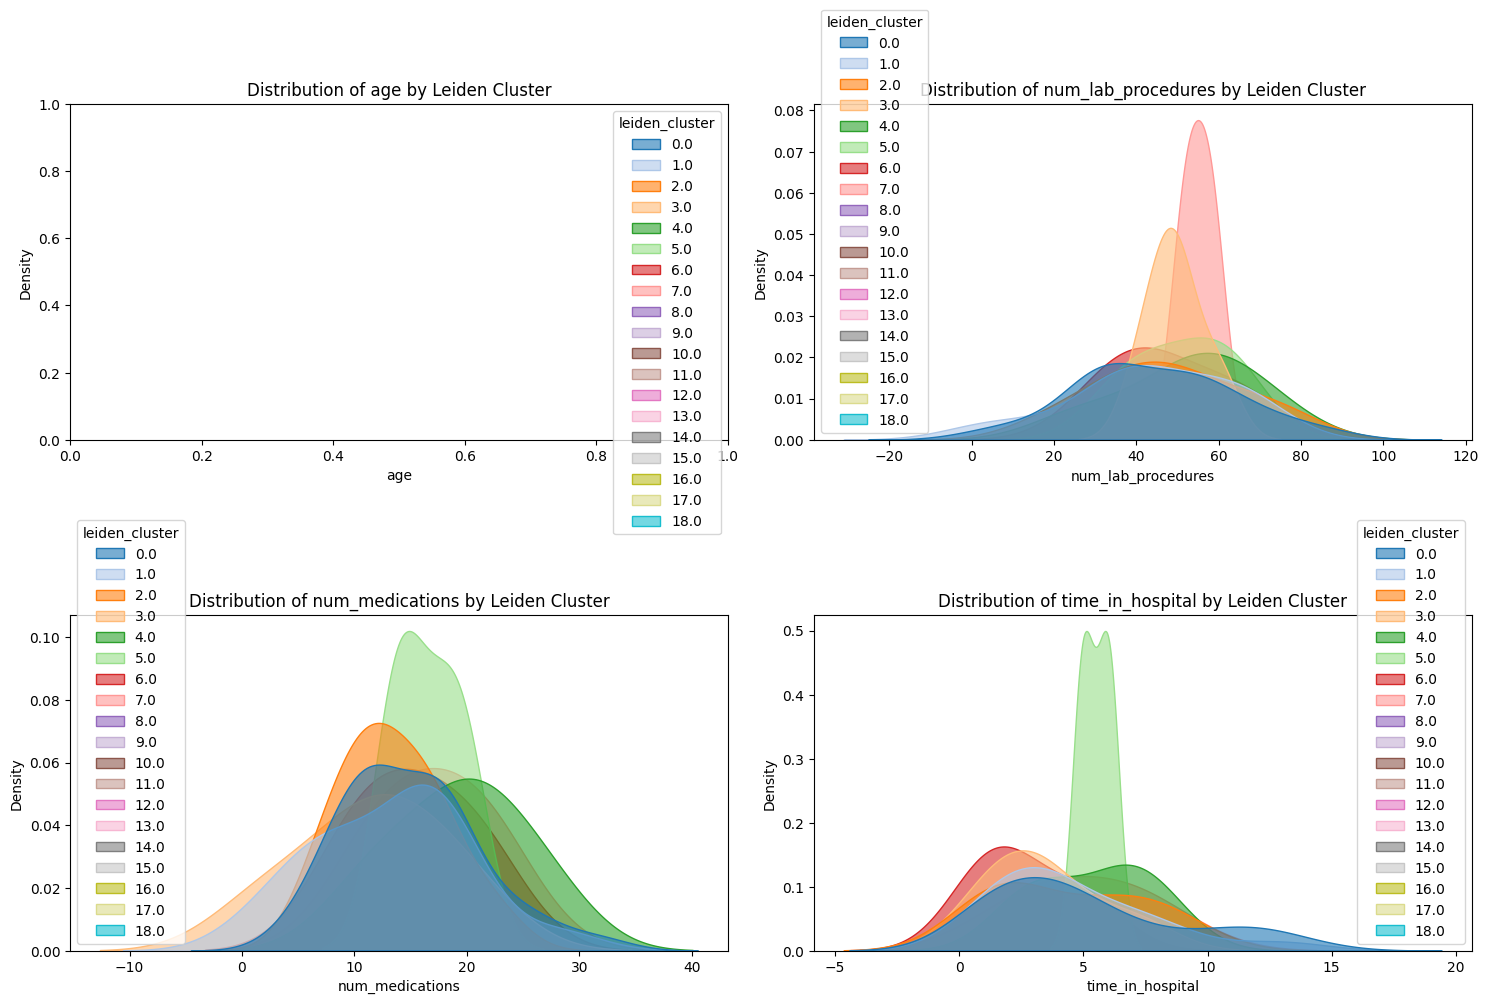

C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\2312879784.py:37: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)
C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\2312879784.py:37: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)
C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\2312879784.py:37: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)


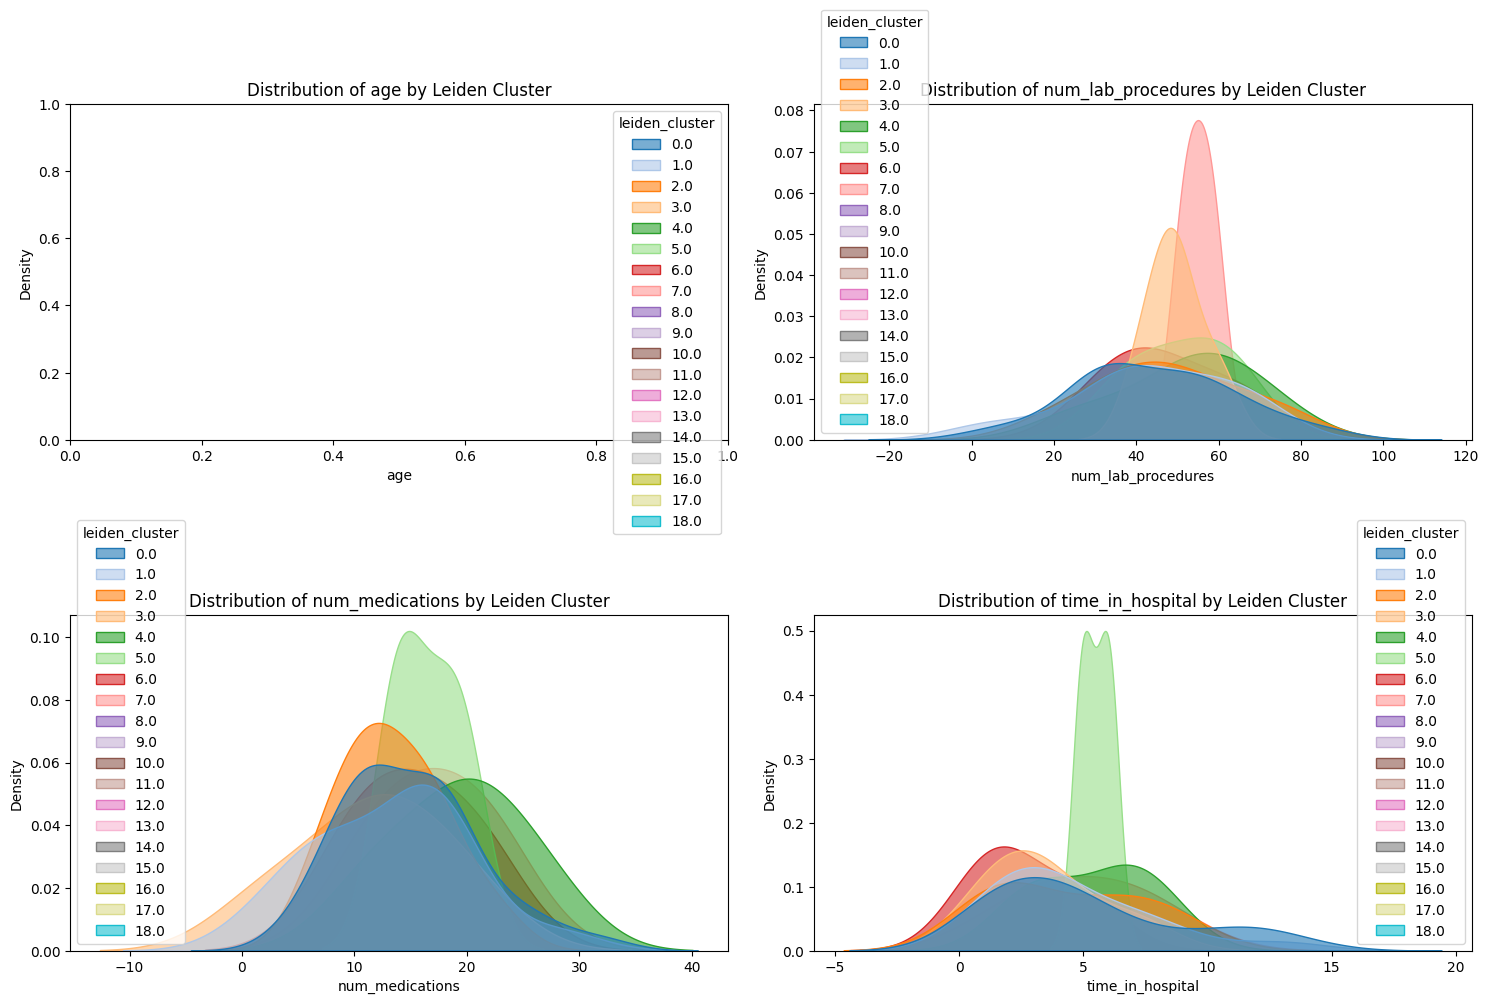

In [14]:
# Load the dataset from the CSV file
df = pd.read_csv('diabetic_data.csv')

# Assuming you've already run the Leiden clustering and have `leiden_clusters`
# Ensure `leiden_clusters` is a dictionary where keys are patient indices or IDs

# Add the Leiden clusters as a new column in the DataFrame
df['leiden_cluster'] = df.index.map(leiden_clusters)

# Define color palette for clusters (using previously defined `color_map`)
cluster_palette = {cluster: color for cluster, color in color_map.items()}

# Plot distribution of selected features per cluster
features_to_plot = ['age', 'num_lab_procedures', 'num_medications', 'time_in_hospital']  # Example features


# Convert relevant columns to numeric if they are not already
for feature in features_to_plot:
    if df[feature].dtype == 'object':
        df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Now retry plotting the distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)
    plt.title(f"Distribution of {feature} by Leiden Cluster")
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=df, x=feature, hue='leiden_cluster', palette=cluster_palette, fill=True, common_norm=False, alpha=0.6)
    plt.title(f"Distribution of {feature} by Leiden Cluster")
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# 1. Cluster Health Pathway Analysis
Objective: Explore the healthcare usage patterns within clusters (e.g., hospital visits, lab procedures, medications) and see how they differ across clusters, especially with respect to readmission likelihood.

Approach:

Compute summary statistics (like average counts of visits, medications) for each cluster.
Use box plots or swarm plots to visualize differences across clusters.
Focus on identifying whether certain clusters have distinct utilization patterns related to readmission status.

In [16]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'leiden_cluster'],
      dtype='object')

C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\684848125.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leiden_cluster', y=feature, ax=axs[i//3, i%3], palette='Set2')
C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\684848125.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leiden_cluster', y=feature, ax=axs[i//3, i%3], palette='Set2')
C:\Users\jdiaz\AppData\Local\Temp\ipykernel_17892\684848125.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leiden_cluster', y=feature, ax=axs[i//3, i%3],

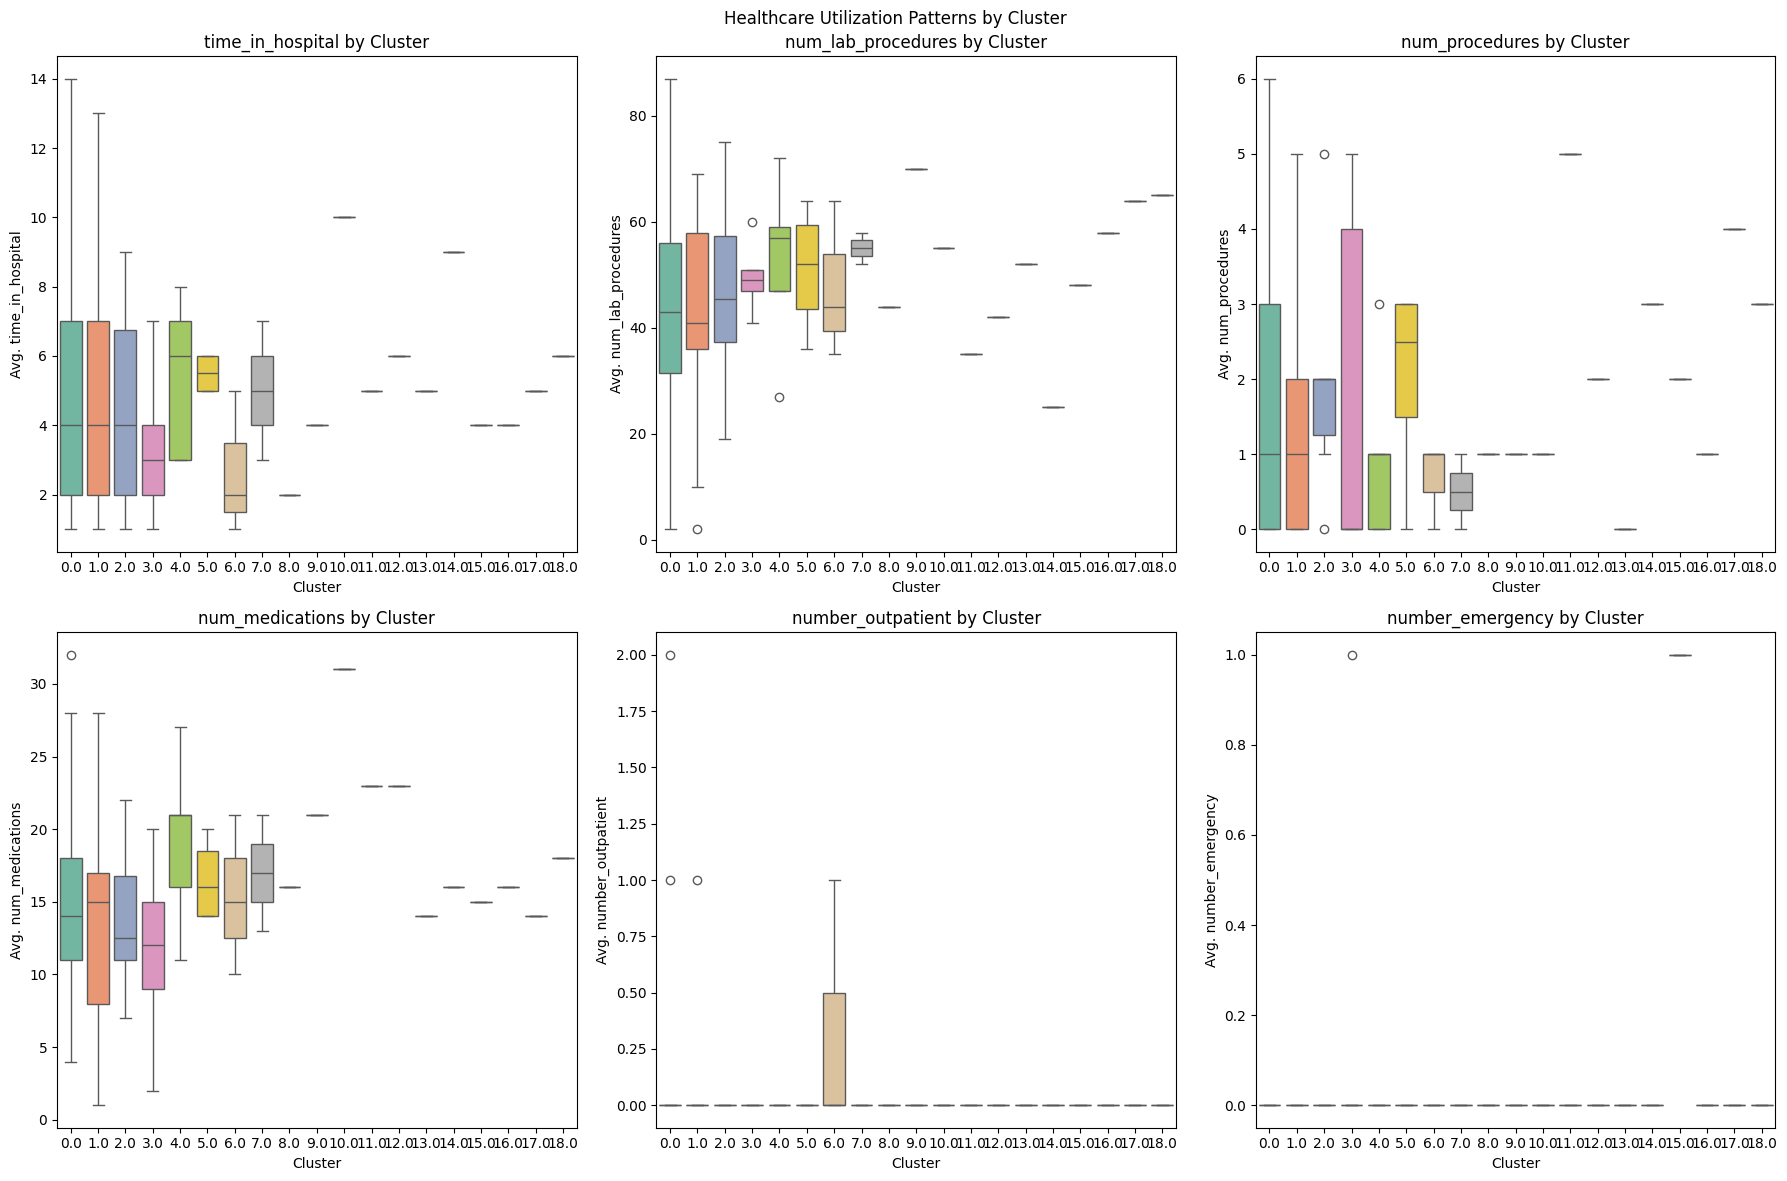

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset data with relevant columns
utilization_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                        'num_medications', 'number_outpatient', 'number_emergency', 
                        'number_inpatient']

# Calculate mean utilization for each cluster
cluster_means = df.groupby('leiden_cluster')[utilization_features].mean().reset_index()

# Visualize using box plots for each feature by cluster
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, feature in enumerate(utilization_features[:6]):
    sns.boxplot(data=df, x='leiden_cluster', y=feature, ax=axs[i//3, i%3], palette='Set2')
    axs[i//3, i%3].set_title(f"{feature} by Cluster")
    axs[i//3, i%3].set_xlabel("Cluster")
    axs[i//3, i%3].set_ylabel(f"Avg. {feature}")

plt.suptitle("Healthcare Utilization Patterns by Cluster")
plt.tight_layout()
plt.show()


In [19]:
pip install pyvis

   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ------------- -------------------------- 262.1/756.0 kB ? eta -:--:--
   ------------- -------------------------- 262.1/756.0 kB ? eta -:--:--
   ------------- -------------------------- 262.1/756.0 kB ? eta -:--:--
   -------------------------- ----------- 524.3/756.0 kB 509.0 kB/s eta 0:00:01
   -------------------------- ----------- 524.3/756.0 kB 509.0 kB/s eta 0:00:01
   -------------------------------------- 756.0/756.0 kB 564.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\fairlearn-0.11.0.dev0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\pyarrow-17.0.0-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [21]:
pip install Jinja2


DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\fairlearn-0.11.0.dev0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jdiaz\appdata\local\programs\python\python311\lib\site-packages\pyarrow-17.0.0-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [22]:
from pyvis.network import Network
import numpy as np

# Initialize the interactive network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Set a color map for clusters
colors = sns.color_palette("tab20", n_colors=df['leiden_cluster'].nunique())
cluster_colors = {i: f"#{int(c[0]*255):02x}{int(c[1]*255):02x}{int(c[2]*255):02x}" for i, c in enumerate(colors)}

# Adding nodes and edges to the network
for node, data in G.nodes(data=True):
    cluster = df.loc[node, 'leiden_cluster']
    time_in_hospital = df.loc[node, 'time_in_hospital']
    net.add_node(
        node, 
        title=f"Patient ID: {node}<br>Cluster: {cluster}<br>Time in Hospital: {time_in_hospital} days",
        color=cluster_colors[cluster],
        size=10 + time_in_hospital * 2  # Size based on time_in_hospital
    )

for source, target in G.edges():
    net.add_edge(source, target)

# Save and display the network
net.show("patient_network.html")

patient_network.html


AttributeError: 'NoneType' object has no attribute 'render'

In [23]:
from pyvis.network import Network
import matplotlib.pyplot as plt

# Initialize the interactive network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Adding nodes and edges from graph `G`
for node, data in G.nodes(data=True):
    readmission_status = df.loc[node, 'readmitted'] if 'readmitted' in df.columns else 'Unknown'
    net.add_node(
        node, 
        title=f"Patient ID: {node}<br>Cluster: {data['leiden_cluster']}<br>Readmitted: {readmission_status}<br>Time in Hospital: {data['time_in_hospital']}",
        color=plt.cm.tab20(data['leiden_cluster'] / len(set(df['leiden_cluster']))),
        size=10 + data['time_in_hospital']  # Adjust size for emphasis
    )

# Adding edges
for source, target in G.edges():
    net.add_edge(source, target)

# Save as HTML file and display
html_file_path = "patient_network.html"
net.save_graph(html_file_path)
print(f"Interactive network saved as {html_file_path}. Open this file in a browser to view.")


Interactive network saved as patient_network.html. Open this file in a browser to view.
